In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random
import statistics
import scipy.sparse as sparse

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [4]:
## Get greatest component of original graph
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G = S[0]

The total number of components is:  12219


In [5]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [6]:
## Project graph into bipartite graph
G_bipartite = nx.Graph()
for node in nodes:
    if list(node.labels)[0] != 'Entity':
        if node.id in G.nodes:
            G_bipartite.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)
vuelta = 0
for officer in labels['Officer']:
    officer_dict = {}
    for officer_neighbors in G.edges(officer):
        for entity_neighbors in G.edges(officer_neighbors[1]):
            if G.nodes[entity_neighbors[1]]['kind'] == 'Intermediary':
                if entity_neighbors[1] in officer_dict:
                    officer_dict[entity_neighbors[1]] =  officer_dict[entity_neighbors[1]] +1
                else:
                    officer_dict[entity_neighbors[1]] = 1
    for k,v in officer_dict.items():
        G_bipartite.add_edge(officer, k, weight=v, type='Interactions')

In [7]:
G_bipartite.number_of_nodes()

164669

In [ ]:
G_bipartite.nodes[list(officer_dict_degree.keys())[0]]

In [14]:
officer_dict_degree

{481167: 306,
 493119: 58,
 521812: 37,
 474906: 34,
 485287: 33,
 521846: 32,
 479980: 31,
 474905: 30,
 493219: 25,
 483545: 22,
 494756: 21,
 452941: 20,
 494753: 20,
 540464: 19,
 521898: 18,
 496053: 18,
 496052: 18,
 497464: 18,
 420202: 17,
 495776: 17,
 497997: 16,
 452940: 16,
 481886: 16,
 441608: 15,
 484548: 15,
 419716: 15,
 496632: 15,
 481944: 14,
 432587: 14,
 495206: 14,
 481878: 13,
 432583: 13,
 494029: 13,
 494770: 13,
 495205: 13,
 480444: 12,
 485675: 12,
 496631: 12,
 465953: 11,
 541514: 11,
 523476: 11,
 523472: 11,
 438192: 11,
 481943: 11,
 525039: 11,
 498738: 11,
 508285: 11,
 489824: 11,
 433528: 11,
 493091: 10,
 521146: 10,
 497753: 10,
 481884: 10,
 494761: 10,
 496827: 10,
 521845: 10,
 484550: 10,
 525040: 10,
 483190: 9,
 481879: 9,
 464100: 9,
 497982: 9,
 533847: 9,
 508283: 9,
 489825: 9,
 500897: 9,
 509843: 9,
 420231: 8,
 443791: 8,
 494779: 8,
 484549: 8,
 496096: 8,
 497347: 8,
 463052: 8,
 493190: 8,
 484627: 8,
 452784: 8,
 495974: 8,
 4985

In [9]:
## Sort node id's by degree
intermediary_dict_degree = dict(G_bipartite.degree(labels['Intermediary']))
officer_dict_degree = dict(G_bipartite.degree(labels['Officer']))
intermediary_dict_degree = {k: v for k, v in sorted(intermediary_dict_degree.items(), key=lambda item: item[1],reverse=True)}
officer_dict_degree = {k: v for k, v in sorted(officer_dict_degree.items(), key=lambda item: item[1],reverse=True)}

In [10]:
## Bipartite adjacency matrix
A=nx.bipartite.biadjacency_matrix(G_bipartite,list(intermediary_dict_degree.keys()),list(officer_dict_degree.keys()))
#A=nx.bipartite.biadjacency_matrix(G_bipartite, labels['Officer'], labels['Intermediary'])

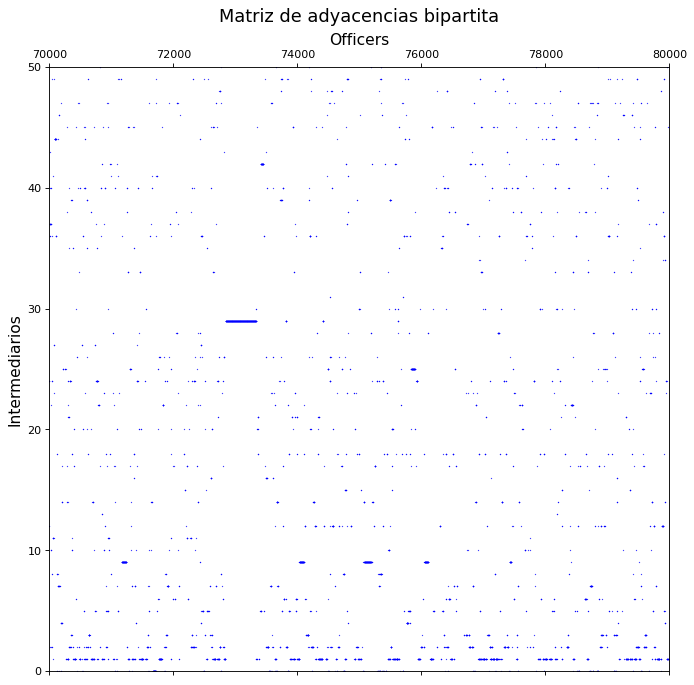

In [24]:
## Plot bipartite adjacency matrix
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.spy(A,aspect="auto", markersize=0.2,alpha =1,color='blue')
axs.set_title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
axs.xaxis.set_label_position('top')
#plt.xlim(70000,80000)
#plt.ylim(0,50)
plt.show()

#plt.figure(figsize=(10, 10), dpi=80)
#plt.register_cmap(cmap=map_object)
#plt.spy(A,aspect="auto", markersize=0.2,alpha =1,color='blue')
#plt.xlabel("Officers",fontsize=14,loc='top')
#plt.ylabel("Intermediarios",fontsize=14)
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)


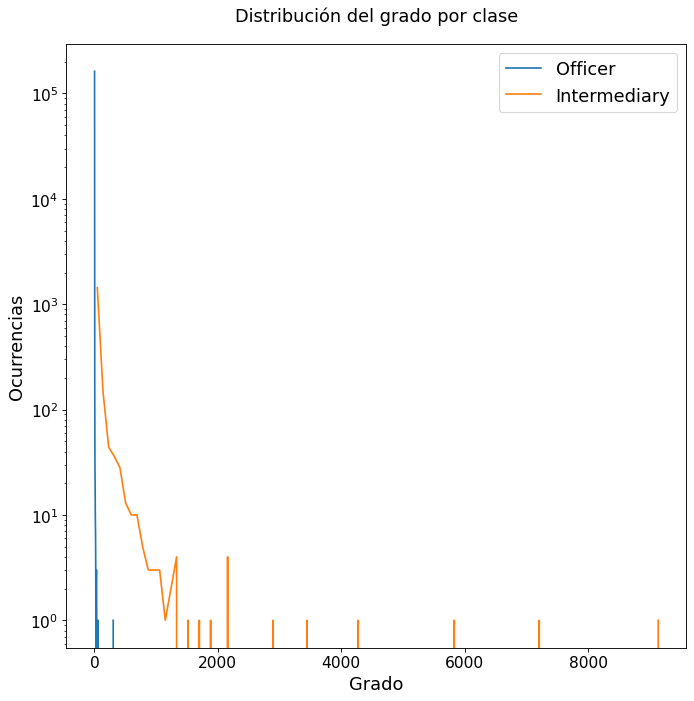

In [21]:
# Degree distribution by class
histogram_degrees_officer = list(dict(G_bipartite.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G_bipartite.degree(labels['Intermediary'])).values())

plt.figure(figsize=(10, 10), dpi=80)

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Distribución del grado por clase',fontsize=16,pad=20)
plt.xlabel('Grado',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
p.show()

In [31]:
# Dict node weight
weight_dict = {}
for u,v,data in G_bipartite.edges(data=True):
    weight_dict[u] = weight_dict.get(u, [])
    weight_dict[u].append(data['weight'])
    weight_dict[v] = weight_dict.get(v, [])
    weight_dict[v].append(data['weight'])

In [32]:
weight_dict_mean = {}
for key,value in weight_dict.items():
    weight_dict_mean[key] = statistics.mean(value)

In [56]:
## Graph bipartite associativity compute
scatter_associativity_officer_mean = []
scatter_associativity_intermediary_mean = []
scatter_associativity_officer_weight_mean = []
scatter_associativity_intermediary_weight_mean = []
scatter_associativity_officer_weight_degree = []
scatter_associativity_intermediary_weight_degree = []

for node_id,metadata in G_bipartite.nodes(data=True):
    node_degree = G_bipartite.degree(node_id)
    degree_mean = 0
    weight_mean = 0
    number_of_neighbors = len(list(G_bipartite.neighbors(node_id)))
    if G_bipartite.nodes[node_id]['kind'] == 'Intermediary':
        scatter_associativity_intermediary_weight_degree.append([node_degree,weight_dict_mean[node_id]])
    else:
        scatter_associativity_officer_weight_degree.append([node_degree,weight_dict_mean[node_id]])
    ## Iterate over neighbors
    for node_neighbor in G_bipartite.neighbors(node_id):
        neighbor_degree = G_bipartite.degree(node_neighbor)
        degree_mean = neighbor_degree + degree_mean
        weight_mean = weight_mean + weight_dict_mean[node_neighbor]
    if G_bipartite.nodes[node_id]['kind'] == 'Intermediary':
        scatter_associativity_intermediary_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_intermediary_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))
    else:
        scatter_associativity_officer_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
        scatter_associativity_officer_weight_mean.append(list([weight_dict_mean[node_id], weight_mean/number_of_neighbors]))        

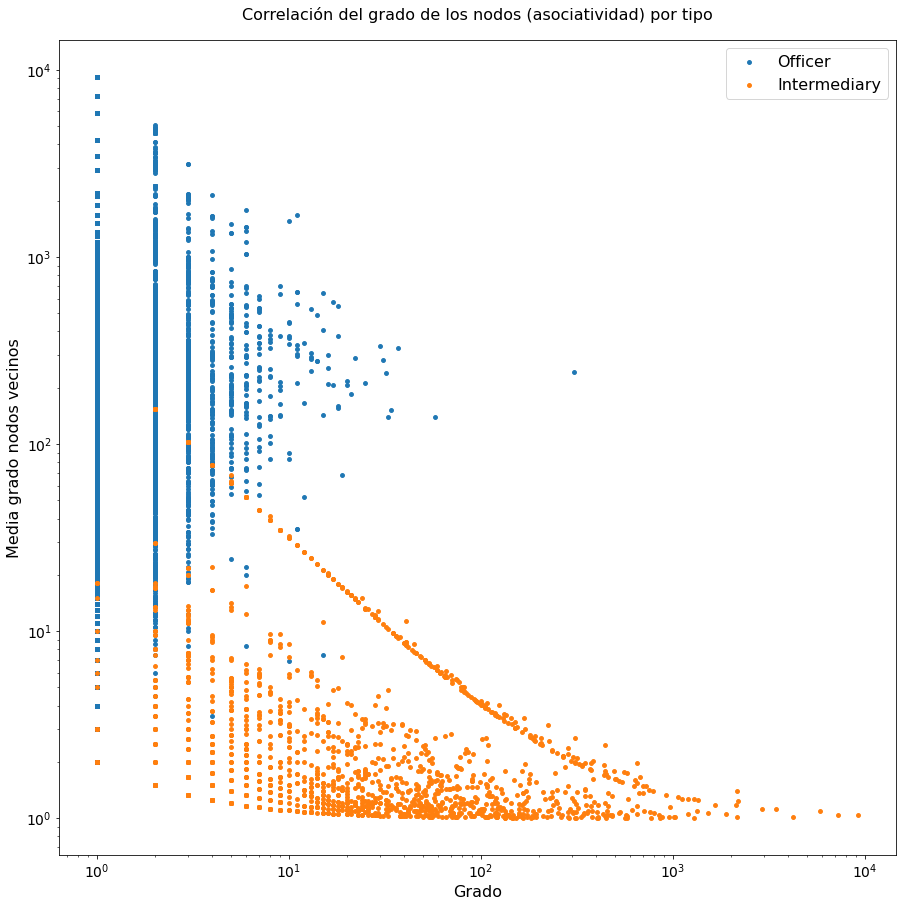

In [34]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
np.mean(y_intermediary)

In [63]:
np.mean(y_officer)

1.176286462968806

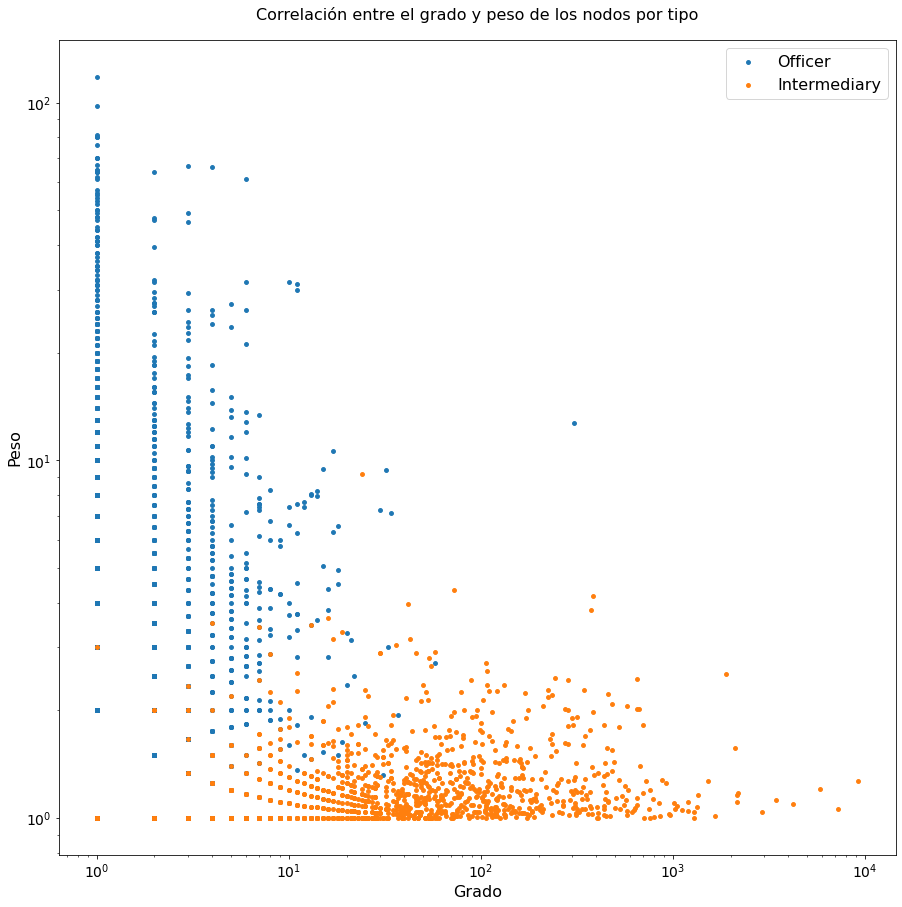

In [59]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_weight_degree)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_weight_degree)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Peso', fontsize=16)
plt.title('Correlación entre el grado y peso de los nodos por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
## Node associativity per node kind (neighbor mean)
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
for key,value in weight_dict_mean.items():
    if value > 100:
        print(key)

In [ ]:
G_bipartite.nodes[221955]

In [ ]:
officer_dict = dict(G_bipartite.degree(labels['Officer']))
sorted_officer_dict = list(dict(sorted(officer_dict.items(), key=lambda item: item[1],reverse=True)).keys())

intermediary_dict = dict(G_bipartite.degree(labels['Intermediary']))
sorted_intermediary_dict = list(dict(sorted(intermediary_dict.items(), key=lambda item: item[1],reverse=True)).keys())

In [ ]:
A=nx.bipartite.biadjacency_matrix(G_bipartite, sorted_officer_dict, sorted_intermediary_dict)

In [45]:
A_dense.shape

(162907, 1762)

In [47]:
A_dense = A.todense().T
A_dense = A_dense.astype('float')
A_dense[A_dense==0.0] = np.nan

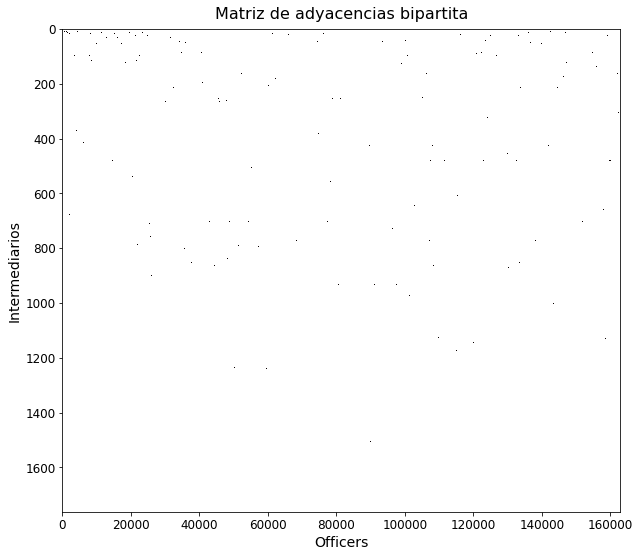

In [50]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
#plt.xlim(0,100000)
#plt.ylim(1000,1762)
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

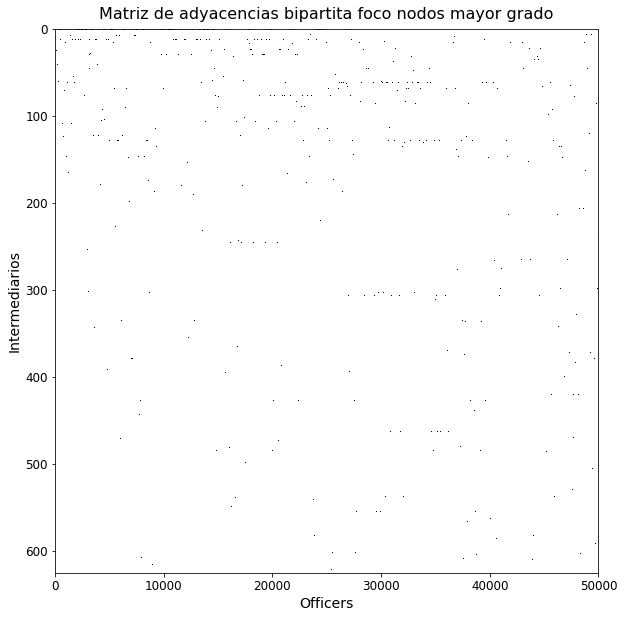

In [51]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita foco nodos mayor grado",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
plt.xlim(0,50000)
plt.ylim(625,0)
plt.xlabel("Officers")
plt.ylabel("Intermediarios")
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

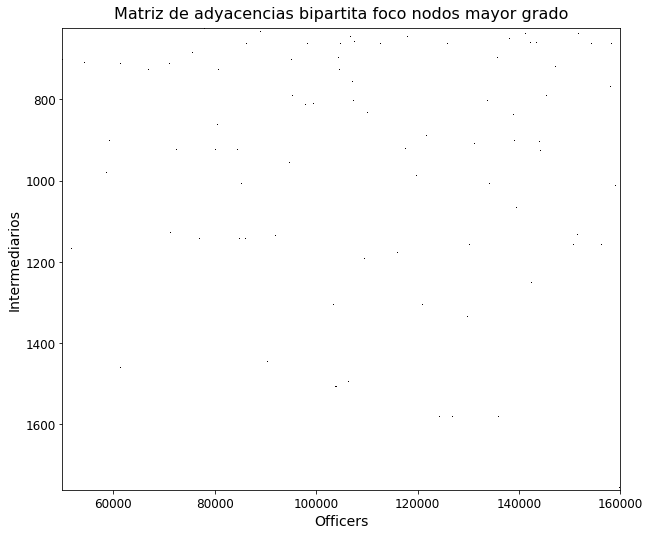

In [53]:
plt.figure(figsize=(10, 10))
plt.title("Matriz de adyacencias bipartita foco nodos mayor grado",pad=10,fontsize=16)
plt.imshow(A_dense, cmap='hot', interpolation='nearest',extent=[0,162907,1762,0], aspect = 80,origin='upper')
#plt.imshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.matshow(A.todense().T, cmap='hot',extent=[0,162907,0,1762], aspect = 80)
#plt.colorbar(fraction=0.04, pad=0.04)
#plt.clim(0,10)
plt.xlim(50000,160000)
plt.ylim(1762,625)
plt.xlabel("Officers")
plt.ylabel("Intermediarios")
plt.xlabel("Officers",fontsize=14)
plt.ylabel("Intermediarios",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [36]:
nx.write_gexf(G_bipartite, "bipartite.gexf")

In [44]:
print(1)

1


In [45]:
nx.is_connected(G_bipartite)

True

In [47]:
G_bipartite.number_of_nodes()

164669

In [14]:
nx.write_edgelist(G_bipartite, "test-bipartite-edgelist.csv",delimiter=",", data=False)

In [10]:
## New graph small relabelled
G_new = G_bipartite.copy()
counter = 0
remove_ids = []
for k,v in officer_dict_degree.items():
    if v == 1:
        counter=counter+1
        remove_ids.append(k)
G_new.remove_nodes_from(remove_ids)
#counter
#old_ids_array = sorted(list(G_new.nodes))
#relabel_nodes = {}
#counter = 0
#for old_id in old_ids_array:
#    relabel_nodes[old_id] = counter
#    counter = counter +1
#H = nx.relabel_nodes(G_new, relabel_nodes)
#nx.write_edgelist(H, "small-bipartite-edgelist.csv",delimiter=",", data=[ "weight"])

## new dict containing arrays on a key per node class
labels = {}
for n, d in H.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)

In [33]:
intermediary_new_mapping = {}
officers_new_mapping = {}
counter=0
for old_id in sorted(list(labels['Intermediary'])):
    intermediary_new_mapping[old_id] = str(counter) + 'i'
    counter=counter+1
counter=0
for old_id in sorted(list(labels['Officer'])):
    officers_new_mapping[old_id] = str(counter) + 'o'
    counter=counter+1
B = nx.Graph()
B.add_nodes_from(intermediary_new_mapping.values(), bipartite=0)
B.add_nodes_from(officers_new_mapping.values(), bipartite=1)
edges_bipartite = []
for u,v,data in H.edges(data=True):
    new_officer_id = None
    new_intermediary_id = None
    if u in intermediary_new_mapping:
        new_intermediary_id = intermediary_new_mapping[u]
    else:
        new_officer_id = officers_new_mapping[u]
    if v in intermediary_new_mapping:
        new_intermediary_id = intermediary_new_mapping[v]
    else:
        new_officer_id = officers_new_mapping[v]
    edges_bipartite.append([new_intermediary_id,new_officer_id,data])
B.add_edges_from(edges_bipartite)

In [61]:
bottom_nodes, top_nodes = nx.bipartite.sets(B)

In [62]:
#nx.write_edgelist(B, "B-bipartite.csv", data=["weight"],delimiter=',')
with open('B-bipartite.csv','w') as file:
    for line in nx.bipartite.generate_edgelist(B,delimiter=',',data=["weight"]):
        file.write(''.join([c for c in line if c in '1234567890,']))
        file.write('\n')
        
intermediary_dict_degree = dict(B.degree(list(intermediary_new_mapping.values())))
officer_dict_degree = dict(B.degree(list(officers_new_mapping.values())))
intermediary_dict_degree = {k: v for k, v in sorted(intermediary_dict_degree.items(), key=lambda item: item[1],reverse=True)}
officer_dict_degree = {k: v for k, v in sorted(officer_dict_degree.items(), key=lambda item: item[1],reverse=True)}
A=nx.bipartite.biadjacency_matrix(B,list(intermediary_dict_degree.keys()),list(officer_dict_degree.keys()))
pd.DataFrame(A.todense()).to_csv("matrix-bipartite.csv",header=None, index=None)

In [ ]:
## Sort node id's by degree
intermediary_dict_degree = dict(H.degree(labels['Intermediary']))
officer_dict_degree = dict(H.degree(labels['Officer']))
intermediary_dict_degree = {k: v for k, v in sorted(intermediary_dict_degree.items(), key=lambda item: item[1],reverse=True)}
officer_dict_degree = {k: v for k, v in sorted(officer_dict_degree.items(), key=lambda item: item[1],reverse=True)}
A=nx.bipartite.biadjacency_matrix(H,list(intermediary_dict_degree.keys()),list(officer_dict_degree.keys()))

In [92]:
#np.savetxt("just-echking-aaa.csv", A.todense(), delimiter=",")
pd.DataFrame(A.todense()).to_csv("just-echking-aaa.csv",header=None, index=None)

In [85]:
type(A.todense())

numpy.matrix

In [86]:
A.todense()

matrix([[ 7,  0,  0, ...,  0,  0,  0],
        [ 1,  0,  0, ...,  0,  0,  0],
        [60,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

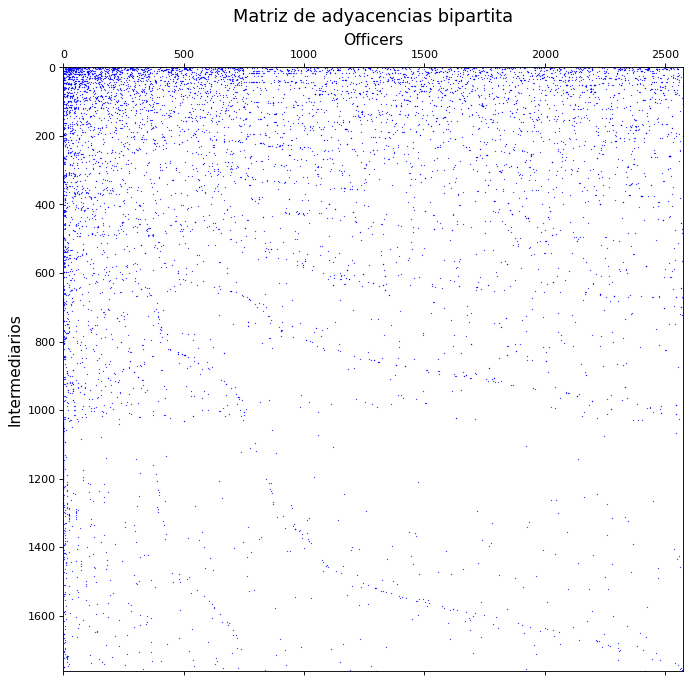

In [87]:
## Plot bipartite adjacency matrix
fig, axs = plt.subplots(figsize=(10, 10),dpi=80)
axs.spy(A,aspect="auto", markersize=0.2,alpha =1,color='blue')
axs.set_title("Matriz de adyacencias bipartita",pad=10,fontsize=16)
axs.set_ylabel("Intermediarios",fontsize=14)
axs.set_xlabel("Officers",fontsize=14)
axs.xaxis.set_label_position('top')
#plt.xlim(70000,80000)
#plt.ylim(0,50)
plt.show()